This is the code about multimodal learning that exploit intermediate fusion.
For the data preprocessing section, we refer the following link: https://github.com/slipnitskaya/caltech-birds-advanced-classification/blob/master/notebook.ipynb

In [ ]:
# import packages
import os
import csv
import random
import tarfile
import multiprocessing as mp

import tqdm
import requests

import numpy as np
import sklearn.model_selection as skms

import torch
import torch.utils.data as td
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
import torchvision.transforms.functional as TF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd


# define constants
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUT_DIR = 'results'
RANDOM_SEED = 42

# create an output folder
os.makedirs(OUT_DIR, exist_ok=True)


def get_model_desc(pretrained=False, num_classes=200, use_attention=False):
    """
    Generates description string.  
    """
    desc = list()

    if pretrained:
        desc.append('Transfer')
    else:
        desc.append('Baseline')

    if num_classes == 204:
        desc.append('Multitask')

    if use_attention:
        desc.append('Attention')

    return '-'.join(desc)


def log_accuracy(path_to_csv, desc, acc, sep='\t', newline='\n'):
    """
    Logs accuracy into a CSV-file.
    """
    file_exists = os.path.exists(path_to_csv)

    mode = 'a'
    if not file_exists:
        mode += '+'

    with open(path_to_csv, mode) as csv:
        if not file_exists:
            csv.write(f'setup{sep}accuracy{newline}')

        csv.write(f'{desc}{sep}{acc}{newline}')

## Data collection<a class="anchor" id="data"></a>

In this tutorial, we are going to use CUB-200-2011 dataset consisting of 11788 images of birds belonging to 200 species. 

The dataset file can be downloaded and extracted manually from [link](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html 'www.vision.caltech.edu'), or, alternatively, using the following code:

After downloading of the compressed file, we extract it and also assess some statistics to verify whether the gathered data consist the expected number of classes and images. Here's an example execution: 

In [ ]:
def extract_tgz(from_path, to_path=None, img_extention='.jpg'):
    """
    Extracts data from '.tgz' file and displays data statistics.
    Returns the output directory name.  
    """
    with tarfile.open(from_path, 'r:gz') as tar:   
        
        if to_path is None:
            out_dir = os.path.splitext(from_path)[0]
        if os.path.isdir(out_dir):
            print('Files are extracted yet.')
        else:
            print('Extracting files...')
        to_path = os.path.dirname(out_dir)

        subdir_and_files = [tarinfo for tarinfo in tar.getmembers()]    
        imgs = [t for t in subdir_and_files if t.name.endswith(img_extention)]
        print('\tClasses: {}\n\tImages: {}'.format(len(set([os.path.dirname(t.name) for t in imgs])), len(imgs)))

        tar.extractall(to_path, members=subdir_and_files)
        
        return out_dir


# extract the downloaded archive & assess data statistics
in_dir_data = extract_tgz(from_path="CUB_200_2011.tgz")

Files are extracted yet.
	Classes: 200
	Images: 11788


## Data exploration


In [ ]:
in_dir_img = os.path.join(in_dir_data, 'images')

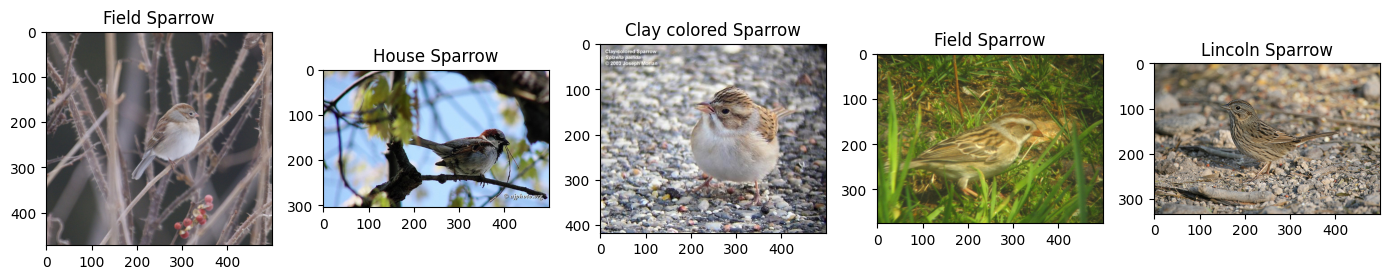

In [ ]:
random.seed(RANDOM_SEED)
in_dir_img = os.path.join(in_dir_data, 'images')

# obtain classes of sparrow species
img_sparrows = dict()
cls_sparrows_total = [k for k in os.listdir(in_dir_img) if 'sparrow' in k.lower()]

# get images of some sparrow classes 
cls_sparrows = cls_sparrows_total[1::2][:5]
for dirname in cls_sparrows:
    imgs = list()
    for dp, _, fn in os.walk(os.path.join(in_dir_img, dirname)):
        imgs.extend(fn)
    img_sparrows[dirname] = imgs

# visualize randomly-chosen images
n_cls = len(cls_sparrows)
f, ax = plt.subplots(1, n_cls, figsize=(14, 8))

for i in range(n_cls):
    cls_name = cls_sparrows[random.randint(0, n_cls - 1)]
    n_img = len(img_sparrows[cls_name])
    img_name = img_sparrows[cls_name][random.randint(0, n_img - 1)]
    path_img = os.path.join(os.path.join(in_dir_img, cls_name), img_name)
    ax[i].imshow(mpimg.imread(path_img))
    ax[i].set_title(cls_name.split('.')[-1].replace('_', ' '),  fontsize=12)

    plt.tight_layout()
plt.show()

As we see, there can be a high similarity among birds related to different species which is really hard to spot. Is that a Song or a White-throated Sparrow? Well, even experts can be confused...

Just out of interest, we'll sum up all classes of the Sparrow family to understand how many of them in our dataset:

In [ ]:
# print the total number of sparrow species
print(len(cls_sparrows_total))

21


There are several dozen different species, represented only by  sparrows. Too much honor ever for one family, isn't it? And now we see why the CUB-200-2011 dataset is perfectly designed for fine-grained classification. What do we have is the many similar birds potentially related to different classes.  

To understand how variable the image size is, let's analyze the widths and heights distribution of images:

In [ ]:
ds = tv.datasets.ImageFolder(in_dir_img)
print(ds)

Dataset ImageFolder
    Number of datapoints: 11788
    Root location: CUB_200_2011/images


Average sizes: 375.0 500.0


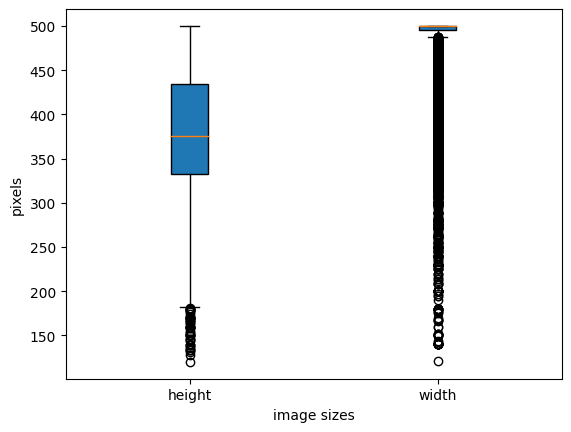

In [ ]:
# calculate image statistics (takes some time to complete)
ds = tv.datasets.ImageFolder(in_dir_img)
shapes = [(img.height, img.width) for img, _ in ds]
heights, widths = [[h for h,_ in shapes], [w for _,w in shapes]]
print('Average sizes:', *map(np.median, zip(*shapes)))

# visualize the distribution of the size of images
fig = plt.figure()
ax = fig.add_subplot(111)

bp = ax.boxplot([heights, widths], patch_artist=True)

ax.set_xticklabels(['height', 'width'])
ax.set_xlabel('image sizes')
ax.set_ylabel('pixels')

plt.show()

Indeed, the size of images varies considerably, with the maximum size of 500 pixels along both dimension. We may also noticed that heights and widths are usually 375 and 500 pixels, respectively. You will see how to use obtained statistics in our the further analysis during the data preparation phase. 

### Question 3: Are there any image-specific biases that can limit the model performance?

In order to choose the appropriate way for the data augmentation later on, we want to estimate the position on which bird are rather to be located. For that, we'll standardize images to its global maximum size, and then visualize an average image, as follows:

In [ ]:
def pad(img, fill=0, size_max=500):
    """
    Pads images to the specified size (height x width). 
    Fills up the padded area with value(s) passed to the `fill` parameter. 
    """
    pad_height = max(0, size_max - img.height) #img.height  shape[1]
    pad_width = max(0, size_max - img.width)   #img.width   shape[2]
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)


It seems like we have to deal with center-biased data, as the majority of birds are located around the middle of images. Thus, it can lead the model to primary focus on that image area, while missing relevant objects located in other parts of images. Next chapter explains how to overcome this problem using data augmentation.


## Data preparation<a class="anchor" id="prep"></a>

CUB-200-2011 dataset contains thousands of images, so it might affect the computational time. To overcome that we first create class `DatasetBirds` to make data loading and pre-processing easy: 

In [ ]:
class DatasetBirds(tv.datasets.ImageFolder):
    """
    Wrapper for the CUB-200-2011 dataset. 
    Method DatasetBirds.__getitem__() returns tuple of image and its corresponding label.    
    """
    def __init__(self,
                 root,
                 transform=None,
                 target_transform=None,
                 loader=tv.datasets.folder.default_loader,
                 is_valid_file=None,
                 train=True,
                 bboxes=False):

        img_root = os.path.join(root, 'images')

        super(DatasetBirds, self).__init__(
            root=img_root,
            transform=None,
            target_transform=None,
            loader=loader,
            is_valid_file=is_valid_file,
        )

        self.transform_ = transform
        self.target_transform_ = target_transform
        self.train = train
        
        # obtain sample ids filtered by split
        path_to_splits = os.path.join(root, 'train_test_split.txt')
        indices_to_use = list()
        with open(path_to_splits, 'r') as in_file:
            for line in in_file:
                idx, use_train = line.strip('\n').split(' ', 2)
                if bool(int(use_train)) == self.train:
                    indices_to_use.append(int(idx))

        # obtain filenames of images
        path_to_index = os.path.join(root, 'images.txt')
        filenames_to_use = list()
        with open(path_to_index, 'r') as in_file:
            for line in in_file:
                idx, fn = line.strip('\n').split(' ', 2)
                #print(fn)
                if int(idx) in indices_to_use:
                    filenames_to_use.append(fn)
        
        img_paths_cut = {'/'.join(img_path.rsplit('/', 2)[-2:]): idx for idx, (img_path, lb) in enumerate(self.imgs)}
        imgs_to_use = [self.imgs[img_paths_cut[fn]] for fn in filenames_to_use]

        _, targets_to_use = list(zip(*imgs_to_use))

        self.imgs = self.samples = imgs_to_use
        self.targets = targets_to_use

        if bboxes:
            # get coordinates of a bounding box
            path_to_bboxes = os.path.join(root, 'bounding_boxes.txt')
            bounding_boxes = list()
            with open(path_to_bboxes, 'r') as in_file:
                for line in in_file:
                    idx, x, y, w, h = map(lambda x: float(x), line.strip('\n').split(' '))
                    if int(idx) in indices_to_use:
                        bounding_boxes.append((x, y, w, h))

            self.bboxes = bounding_boxes
        else:
            self.bboxes = None
            
        ########################################
        ## Attributes
        ########################################
        in_dir_attributes = os.path.join(in_dir_data, 'attributes')
        path_to_attributes = os.path.join(in_dir_attributes, 'image_attribute_labels.txt')
        attributes_dict = {}
        with open(path_to_attributes, 'r') as in_file:
            for line in in_file:
                idx, attr_id, attr_present, _, _ = line.strip('\n').split(' ',4)
                idx = int(idx)
                attr_present = int(attr_present)
                if idx in indices_to_use:
                    if idx not in attributes_dict:
                        attributes_dict[idx] = [attr_present]
                    else:
                        attributes_dict[idx].append(attr_present)

        self.attributes = [attributes_dict[idx] for idx in sorted(attributes_dict.keys())]
        

    def __getitem__(self, index):
        # generate one sample
        sample, target = super(DatasetBirds, self).__getitem__(index)

        if self.bboxes is not None:
            # squeeze coordinates of the bounding box to range [0, 1]
            width, height = sample.width, sample.height
            x, y, w, h = self.bboxes[index]

            scale_resize = 500 / width
            scale_resize_crop = scale_resize * (375 / 500)

            x_rel = scale_resize_crop * x / 375
            y_rel = scale_resize_crop * y / 375
            w_rel = scale_resize_crop * w / 375
            h_rel = scale_resize_crop * h / 375

            target = torch.tensor([target, x_rel, y_rel, w_rel, h_rel]).to(DEVICE)

        if self.transform_ is not None:
            sample = self.transform_(sample)
        if self.target_transform_ is not None:
            target = self.target_transform_(target)
            
        attributes = torch.tensor(self.attributes[index]).to(DEVICE)

        return sample, attributes, target

### Transforming and Splitting the data 

In order to improve the ability of the model to learn the representation of birds, we are going to use data augmentation. As you may have noticed in our previous analysis, the image size varies considerably, images have rather a landscape layout and the width is commonly close to the maximum value along both dimensions.

So before getting to a real deep learning, we'll apply our data-driven approach to transform images. To maintain the aspect ratio of images, we can transform them similarly, so that both dimensions are equal to 500 pixels. Here, it will be done using the maximum padding strategy:

In [ ]:
# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))
# pad images to 500 pixels
max_padding = tv.transforms.Lambda(lambda x: pad(x, fill=fill))

Previously, we have also found the majority of images to be center-biased. To overcome this problem, we make the model able to capture birds everywhere by randomly-cropping and flipping images along both axes during the model training. 

At the same time, test images will be center-cropped by 375 pixels before feeding into the model, given the majority birds are located at this middle area as we found before. Then, we are going to normalize all images by ImageNet's statistics, as follows:

In [ ]:
# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))

# transform images
transforms_train = tv.transforms.Compose([
   max_padding,
   tv.transforms.RandomOrder([
       tv.transforms.RandomCrop((375, 375)),
       tv.transforms.RandomHorizontalFlip(),
       tv.transforms.RandomVerticalFlip()
   ]),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_eval = tv.transforms.Compose([
   max_padding,
   tv.transforms.CenterCrop((375, 375)),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# only keep the top 10 classes
top_10_classes = [199, 198, 197,196, 194, 193, 192, 191, 190, 188]
def filter_top_10_classes(data: torch.utils.data.Dataset):
    indices_to_keep = []
    for i in range(len(data)):
        label = data[i][2]
        if label in top_10_classes:
            indices_to_keep.append(i)
    return torch.utils.data.Subset(data, indices_to_keep)

In [ ]:
# instantiate dataset objects according to the pre-defined splits
ds_train = DatasetBirds(in_dir_data, transform=transforms_train, train=True)
ds_val = DatasetBirds(in_dir_data, transform=transforms_eval, train=True)
ds_test = DatasetBirds(in_dir_data, transform=transforms_eval, train=False)


In [ ]:
# keep top 10 classes
ds_train_filtered = filter_top_10_classes(ds_train)
ds_val_filtered = filter_top_10_classes(ds_val)
ds_test_filtered = filter_top_10_classes(ds_test)

In [ ]:
original_targets = ds_train.targets
filtered_indices = ds_train_filtered.indices
filtered_targets = [original_targets[i] for i in filtered_indices]
splits = skms.StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
idx_train, idx_val = next(splits.split(np.zeros(len(ds_train_filtered)), filtered_targets))

5994
300


In [ ]:
# set hyper-parameters
params = {'batch_size': 12} # 24
num_epochs = 100
num_classes = 200

In [ ]:
# instantiate data loaders
train_loader = td.DataLoader(
   dataset=ds_train_filtered,
   sampler=td.SubsetRandomSampler(idx_train),
   **params
)
val_loader = td.DataLoader(
   dataset=ds_val_filtered,
   sampler=td.SubsetRandomSampler(idx_val),
   **params
)
test_loader = td.DataLoader(dataset=ds_test_filtered, **params)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [ ]:
class MultimodalModel(nn.Module):
    def __init__(self, image_feature_dim, attribute_dim, num_classes):
        super(MultimodalModel, self).__init__()

        self.image_feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(43264, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256)
        )
        
        self.attribute_encoder = nn.Linear(attribute_dim, 256) # 256
        self.classifier = nn.Linear(256 * 2, num_classes)

    def forward(self, image, attributes):
        image_features = self.image_feature_extractor(image)
        
        attribute_features = self.attribute_encoder(attributes)
        combined_features = torch.cat([image_features, attribute_features], dim=1)
        output = self.classifier(combined_features)
        return output

In [ ]:
# Create the multimodal model
image_feature_dim = 375 * 375 * 3
attribute_dim = len(ds_train_filtered[0][1])
num_classes = 200
model = MultimodalModel(image_feature_dim, attribute_dim, num_classes).to(DEVICE)

In [ ]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    i=0
    for images, attributes, targets in train_loader:
        i+=1
        images = torch.tensor(images).to(DEVICE)
        attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
        targets = torch.tensor(targets).to(torch.long).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images, attributes).to(torch.float32)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # Validate the model
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, attributes, targets in val_loader:
            images = torch.tensor(images).to(DEVICE)
            attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
            targets = torch.tensor(targets).to(torch.long).to(DEVICE)

            outputs = model(images, attributes).to(torch.float32)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {100 *correct / total}%')

/tmp/ipykernel_712294/124607810.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE)  #torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
/tmp/ipykernel_712294/124607810.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
/tmp/ipykernel_712294/124607810.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Epoch [1/20], Step [10/23], Loss: 2.024022102355957
Epoch [1/20], Step [20/23], Loss: 2.689054489135742


/tmp/ipykernel_712294/124607810.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE) # torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
/tmp/ipykernel_712294/124607810.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
/tmp/ipykernel_712294/124607810.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Epoch [1/20], Validation Accuracy: 10.0%
Epoch [2/20], Step [10/23], Loss: 2.585855722427368
Epoch [2/20], Step [20/23], Loss: 2.3151137828826904
Epoch [2/20], Validation Accuracy: 13.333333333333334%
Epoch [3/20], Step [10/23], Loss: 2.2592761516571045
Epoch [3/20], Step [20/23], Loss: 2.2259397506713867
Epoch [3/20], Validation Accuracy: 36.666666666666664%
Epoch [4/20], Step [10/23], Loss: 2.3527166843414307
Epoch [4/20], Step [20/23], Loss: 1.9401655197143555
Epoch [4/20], Validation Accuracy: 46.666666666666664%
Epoch [5/20], Step [10/23], Loss: 1.9499324560165405
Epoch [5/20], Step [20/23], Loss: 1.9027577638626099
Epoch [5/20], Validation Accuracy: 46.666666666666664%
Epoch [6/20], Step [10/23], Loss: 2.0803070068359375
Epoch [6/20], Step [20/23], Loss: 1.5001722574234009
Epoch [6/20], Validation Accuracy: 53.333333333333336%
Epoch [7/20], Step [10/23], Loss: 1.5537875890731812
Epoch [7/20], Step [20/23], Loss: 1.6073726415634155
Epoch [7/20], Validation Accuracy: 56.66666666666

In [ ]:
with torch.no_grad():
    total = 0
    correct = 0
    for images, attributes, targets in test_loader:
        images = torch.tensor(images).to(DEVICE)
        attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
        targets = torch.tensor(targets).to(torch.long).to(DEVICE)

        outputs = model(images, attributes).to(torch.float32)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Test Accuracy: {100 *correct / total}%')

/tmp/ipykernel_712294/4284051677.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(DEVICE)# torch.tensor(images.view(images.size(0), -1)).to(DEVICE)
/tmp/ipykernel_712294/4284051677.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attributes = torch.tensor(attributes).to(torch.float32).to(DEVICE)
/tmp/ipykernel_712294/4284051677.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(torch.long).to(DEVICE)


Test Accuracy: 63.333333333333336%
